In [26]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
from aesara_theano_fallback import aesara as theano
import astropy.units as u
from astropy.table import Table
import astrotools.generateExoplanetTable as genTab
import astrotools.orbitparams as orb
import random
import copy

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

import exoplanet
exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.3'


In [2]:
hostname = "HD 260655"

In [3]:
sectors = lk.search_lightcurve(hostname, author='SPOC')

In [4]:
sectors

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 43,2021,SPOC,120,307809773,0.0
1,TESS Sector 44,2021,SPOC,120,307809773,0.0
2,TESS Sector 45,2021,SPOC,120,307809773,0.0
3,TESS Sector 71,2023,SPOC,20,307809773,0.0
4,TESS Sector 72,2023,SPOC,20,307809773,0.0
5,TESS Sector 71,2023,SPOC,120,307809773,0.0
6,TESS Sector 72,2023,SPOC,120,307809773,0.0


In [5]:
sector_numbers = []
for sector in sectors.mission: sector_numbers.append(int(sector[-2:]))
sector_numbers = np.array(sector_numbers)
sector_numbers

array([43, 44, 45, 71, 72, 71, 72])

In [6]:
use_20s_cadence_if_possible = False

times, fluxes, texps, unique_sector_numbers = [], [], [], []
for i, secnum in enumerate(sector_numbers): 
    print(f"Working on {i}th Sector {secnum}")
    print(f"   exptime: {sectors.exptime[i]}")

    nsectors = np.argwhere(sector_numbers==secnum).shape[0]
    # kludgey way to get high cadence data if it exists, otherwise just normal data
    if nsectors == 1: lc_file = lk.search_lightcurve(hostname, sector=secnum,
                                   author="SPOC"
                                  ).download(quality_bitmask="hardest", flux_column="pdcsap_flux")
    else: 
        if sectors.exptime[i].value==120 and use_20s_cadence_if_possible==True: 
            print(f"   Skipping this one because 120 s cadence")
            continue
        elif sectors.exptime[i].value==20 and use_20s_cadence_if_possible==False: 
            print(f"   Skipping this one because 20 s cadence")
            continue
        else:
            if use_20s_cadence_if_possible: exptime = 20
            else: exptime = 120
            lc_file = lk.search_lightcurve(hostname, sector=secnum, exptime=exptime,
                                   author="SPOC"
                                  ).download(quality_bitmask="hardest", flux_column="pdcsap_flux")
    lc = lc_file.remove_nans().normalize().remove_outliers()
    time = lc.time.value
    flux = lc.flux
    
    with fits.open(lc_file.filename) as hdu: hdr = hdu[1].header

    texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
    texp /= 60.0 * 60.0 * 24.0

    times.append(time)
    fluxes.append(flux)
    texps.append(texp) # seconds
    unique_sector_numbers.append(secnum)

Working on 0th Sector 43
   exptime: 120.0 s
Working on 1th Sector 44
   exptime: 120.0 s
Working on 2th Sector 45
   exptime: 120.0 s
Working on 3th Sector 71
   exptime: 20.0 s
   Skipping this one because 20 s cadence
Working on 4th Sector 72
   exptime: 20.0 s
   Skipping this one because 20 s cadence
Working on 5th Sector 71
   exptime: 120.0 s
Working on 6th Sector 72
   exptime: 120.0 s


43 0.001388888888888889
44 0.001388888888888889
45 0.001388888888888889
71 0.001388888888888889
72 0.001388888888888889


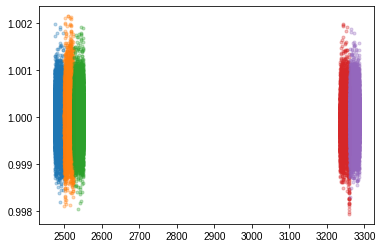

In [10]:
for i in range(len(times)):
    plt.plot(times[i], fluxes[i], '.', alpha=0.3)
    print(unique_sector_numbers[i], texps[i])

In [30]:
#time = np.hstack(times)
#flux = np.hstack(fluxes)
sector_ind = 3
sector_ind_start, sector_ind_end = 3, 5
time = np.hstack(times[sector_ind_start:sector_ind_end])
flux = np.hstack(fluxes[sector_ind_start:sector_ind_end])
texp = texps[sector_ind]

0.001388888888888889

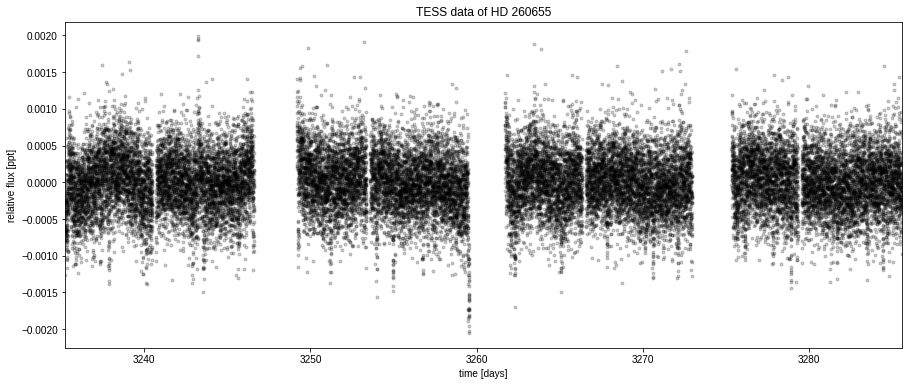

In [31]:
%matplotlib inline
ref_time = 0.5 * (np.min(time) + np.max(time))
x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(flux - 1.0, dtype=np.float64)

%matplotlib inline
plt.figure(figsize=(15, 6))
plt.title(f'TESS data of {hostname}')
plt.plot(x, y, ".k", alpha=0.2)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x.min(), x.max())

texp

In [32]:
# priors
system = genTab.generateExoSystem(hostname=hostname)
system

Accessing NASA Exoplanet Archive
Table of exoplanets retrieved
Writing table to ./NASAExoArchive_ExoplanetSystem_HD260655.dat


hostname,pl_name,sy_dist,sy_disterr1,sy_disterr2,rastr,decstr,sy_vmag,sy_jmag,sy_kmag,st_mass,st_masserr1,st_masserr2,st_rad,st_raderr1,st_raderr2,st_teff,st_tefferr1,st_tefferr2,st_tefferr12,st_tefferr22,st_logg,st_lum,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbincl,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_eqt,pl_ratror,pl_ratrorerr1,pl_ratrorerr2,pl_ratdor,pl_ratdorerr1,pl_ratdorerr2,tran_flag,rv_flag
,,pc,pc,pc,deg,deg,mag,mag,mag,Msun,Msun,Msun,Rsun,Rsun,Rsun,K,K,K,K,K,log(cm/s**2),log(Lsun),day,day,day,Rearth,Rearth,Rearth,Mearth,Mearth,Mearth,day,day,day,AU,AU,AU,deg,,,,K,,,,,,,,
object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32
HD 260655,HD 260655 b,10.0055,0.00505,-0.00505,06h37m09.97s,+17d33m58.57s,9.63,6.674,5.862,0.44,0.01,-0.01,0.44,0.0,-0.0,3803.0,10.0,-10.0,10.0,-10.0,5.2,-1.44,2459497.9102,0.0003,-0.0003,1.24,0.023,-0.023,2.14,0.34,-0.34,2.76953,3e-05,-3e-05,0.02933,0.00024,-0.00024,87.35,0.039,0.043,-0.023,709.0,0.02586,0.00046,-0.00046,14.43,0.29,-0.29,1,1
HD 260655,HD 260655 c,10.0055,0.00505,-0.00505,06h37m09.97s,+17d33m58.57s,9.63,6.674,5.862,0.44,0.01,-0.01,0.44,0.0,-0.0,3803.0,10.0,-10.0,10.0,-10.0,5.2,-1.44,2459490.3646,0.0004,-0.0004,1.533,0.051,-0.046,3.09,0.48,-0.48,5.70588,7e-05,-7e-05,0.04749,0.00039,-0.00039,87.79,0.038,0.036,-0.022,557.0,0.032,0.001,-0.001,23.37,0.47,-0.47,1,1


In [33]:
T0        = np.array(system['pl_tranmid'])-2457000                                        # days
T0_unc    = np.mean([abs(system['pl_tranmiderr1']), abs(system['pl_tranmiderr2'])], axis=0) # days 
P         = np.array(system['pl_orbper'])                                                 # days
P_unc     = np.mean([abs(system['pl_orbpererr1']), abs(system['pl_orbpererr2'])], axis=0)   # days 
Rp        = np.array(system['pl_rade']) * u.R_earth                                               # Earth radii
Rp_unc    = np.mean([abs(system['pl_radeerr1']), abs(system['pl_radeerr2'])], axis=0) * u.R_earth   # Earth radii
Rs        = system['st_rad'][0] * u.R_sun         # Solar radii
Rs_unc    = np.mean([abs(system['st_raderr1'][0]), abs(system['st_raderr2'][0])]) * u.R_sun         # Solar radii
Ms        = system['st_mass'][0] * u.M_sun         # Solar radii
Ms_unc    = np.mean([abs(system['st_masserr1'][0]), abs(system['st_masserr2'][0])], axis=0) * u.M_sun         # Solar radii

depth     = ((Rp/Rs)**2).decompose().value
depth_unc = (depth * np.sqrt((Rp_unc/Rp)**2 + (Rs_unc/Rs)**2)).decompose().value

M_star = Ms.value, Ms_unc.value
R_star = Rs.value, Rs_unc.value

shape = len(system)

depth_unc

array([1.23817722e-05, 3.22787852e-05])

(3235.2324483947036, 3285.58749341453)

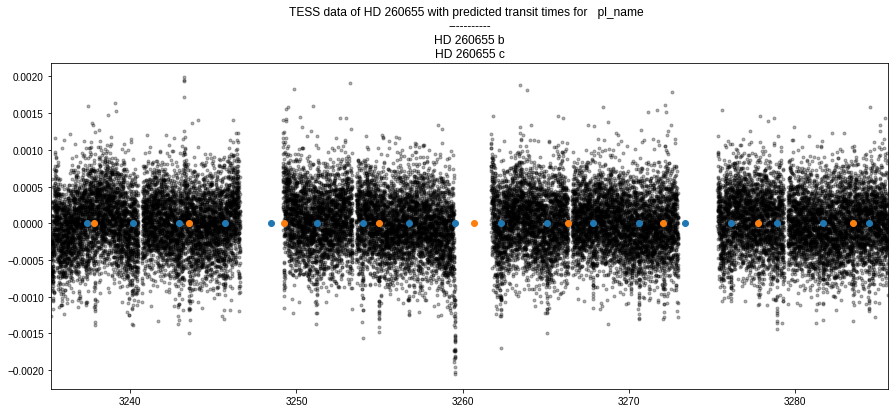

In [34]:
%matplotlib inline
plt.figure(figsize=(15, 6))
plt.title(f'TESS data of {hostname} with predicted transit times for {system["pl_name"][:]}')
plt.plot(x, y, 'k.', alpha=0.3)
n = np.arange(-1000, 1000)
for i in range(len(system)):
    t = T0[i] + n*P[i]
    plt.plot(t, [0 for i in t], 'o', zorder=1000)
plt.xlim(x[0], x[-1])

In [35]:
phase_lc = np.linspace(-0.3, 0.3, 100)

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=0.001)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Stellar parameters from Luque (2019)
        #M_star = 0.342, 0.011
        #R_star = 0.337, 0.015
        #BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=0.5)
        #m_star = BoundedNormal(
        #    "m_star", mu=M_star[0], sd=M_star[1]
        #)
        #r_star = BoundedNormal(
        #    "r_star", mu=R_star[0], sd=R_star[1]
        #)
        m_star, r_star = M_star[0], R_star[0]

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=T0, sd=T0_unc, shape=shape)
        log_period = pm.Normal("log_period", mu=np.log(P), sd=P_unc, shape=shape)
        period = pm.Deterministic("period", tt.exp(log_period))
        
        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1, shape=shape)
        log_depth = pm.Normal("log_depth", mu=np.log(depth), sigma=depth_unc, shape=shape)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                tt.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        
        #         log_r_pl = pm.Normal(
        #             "log_r_pl",
        #             sd=1.0,
        #             mu=0.5 * np.log(1e-3 * np.array(bls_depth))
        #             + np.log(R_star_huang[0]),
        #         )
        #         r_pl = pm.Deterministic("r_pl", tt.exp(log_r_pl))
        #         ror = pm.Deterministic("ror", r_pl / r_star)
        #         b = xo.distributions.ImpactParameter("b", ror=ror)

        #ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        #ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        #omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        #xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)
        
        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=0.1
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=0.01)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=0.1
        )

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            #ecc=ecc,
            #omega=omega,
        )

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)
        )
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.Matern32Term(
            sigma=tt.exp(log_sigma_gp),
            rho=tt.exp(log_rho_gp),
        )
        gp = GaussianProcess(kernel, t=x[mask], yerr=tt.exp(log_sigma_lc))
        gp.marginal("gp", observed=resid)
        #         pm.Deterministic("gp_pred", gp.predict(resid))

        # Compute and save the phased light curve models      
        #pm.Deterministic(
        #    f"lc_pred_{i}",
        #    xo.LimbDarkLightCurve(*u_star
        #                  ).get_light_curve(orbit=orbit, 
        #                                    r=r_pl, 
        #                                    t=t0+phase_lc, 
        #                                    texp=texp
        #                                   ).eval()
        #)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(
            start=start, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        #map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        #map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves", "gp_pred"],
                pmx.eval_in_model([light_curves, gp.predict(resid)], map_soln),
            )
        )

    return model, map_soln, extras


In [36]:
%matplotlib inline
model0, map_soln0, extras0 = build_model()

optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: 195709.12566531103 -> 195774.98530172987
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: 195774.98530172987 -> 195831.7182696849
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: 195831.7182696849 -> 196281.40088363216
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: 196281.40088363216 -> 196449.62648518584
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: 196449.62648518584 -> 196449.62653039512


optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: 196449.62653039512 -> 196542.03858280767
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: 196542.03858280767 -> 196542.05676102955
optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: 196542.05676102955 -> 196563.41333469193
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, log_depth, b, log_period, t0, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 196563.41333469193 -> 196620.26955653267


In [37]:
%matplotlib inline
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(15, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = extras["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.plot(t, [0 for i in t], '.', color='C2', zorder=1000)
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, t0 in enumerate(soln["t0"]):
        mod = extras["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(system[i]['pl_name']))
    #ax.plot(t, [0 for i in t], '.', color='C0', zorder=1000)
    ax.legend(fontsize=10, loc=3, ncol=len(soln["t0"])+1)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(extras["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


_ = plot_light_curve(map_soln0, extras0)

In [38]:
#mod = (
#    extras0["gp_pred"]
#    + map_soln0["mean"]
#    + np.sum(extras0["light_curves"], axis=-1)
#)
#resid = y - mod
#rms = np.sqrt(np.median(resid**2))
#mask = np.abs(resid) < 7 * rms

#plt.figure(figsize=(10, 5))
#plt.plot(x, resid, "k", label="data")
#plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
#plt.axhline(0, color="#aaaaaa", lw=1)
#plt.ylabel("residuals [ppt]")
#plt.xlabel("time [days]")
#plt.legend(fontsize=12, loc=3)
#_ = plt.xlim(x.min(), x.max())

In [39]:
#model, map_soln, extras = build_model(mask, map_soln0)
#_ = plot_light_curve(map_soln, extras, mask)

In [40]:
with model0:
    trace = pm.sample(
        tune=500,
        draws=1000,
        start=map_soln0,
        cores=1,
        chains=2,
        #target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma_gp, log_rho_gp, log_sigma_lc, log_depth, b, log_period, t0, u_star, mean]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1633 seconds.


In [41]:
import arviz as az

az.summary(
    trace,
    var_names=[
        #"omega",
        #"ecc",
        "r_pl",
        "ror",
        "b",
        "t0",
        "period",
        #"r_star",
        #"m_star",
        "u_star",
        "mean",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r_pl[0],0.011,0.000,0.011,0.011,0.000,0.000,1188.0,937.0,1.0
r_pl[1],0.015,0.000,0.015,0.015,0.000,0.000,2727.0,1730.0,1.0
ror[0],0.025,0.000,0.024,0.025,0.000,0.000,1188.0,937.0,1.0
ror[1],0.034,0.000,0.033,0.035,0.000,0.000,2727.0,1730.0,1.0
b[0],0.635,0.018,0.603,0.668,0.000,0.000,1522.0,1223.0,1.0
b[1],0.885,0.007,0.871,0.899,0.000,0.000,1521.0,1410.0,1.0
t0[0],2497.910,0.000,2497.910,2497.911,0.000,0.000,1401.0,1614.0,1.0
t0[1],2490.365,0.000,2490.364,2490.365,0.000,0.000,1647.0,1173.0,1.0
period[0],2.769,0.000,2.769,2.769,0.000,0.000,1432.0,1549.0,1.0
period[1],5.706,0.000,5.706,5.706,0.000,0.000,1591.0,1366.0,1.0


<Figure size 432x288 with 0 Axes>

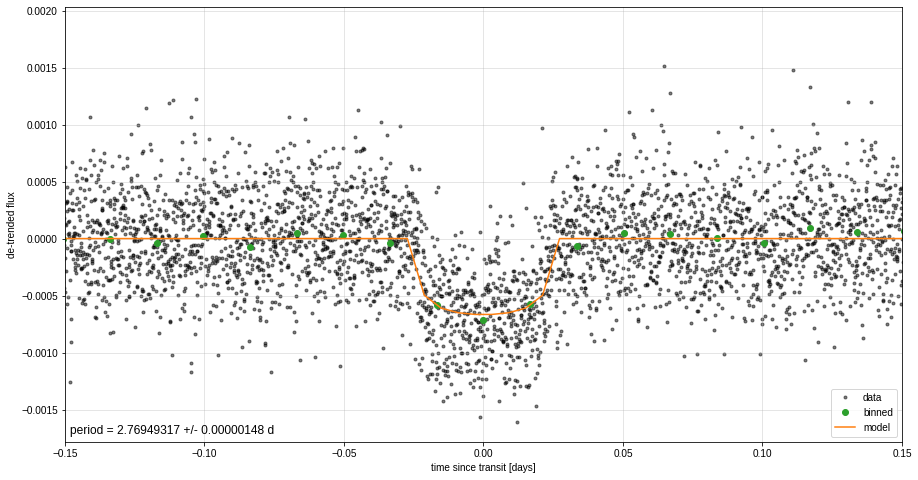

<Figure size 432x288 with 0 Axes>

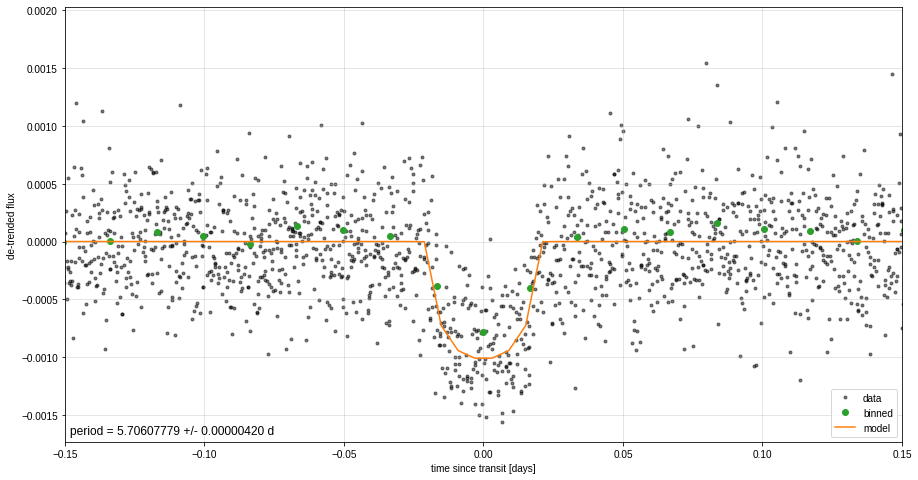

In [42]:
%matplotlib inline

flat_samps = trace.posterior.stack(sample=("chain", "draw"))
gp_mod = extras0["gp_pred"] + map_soln0["mean"]

for i in range(len(system)):
    plt.figure()


    # Compute the GP prediction
    #gp_mod = extras0["gp_pred"] + map_soln0["mean"]  # np.median(
    #     flat_samps["gp_pred"].values + flat_samps["mean"].values[None, :], axis=-1
    # )

    # Get the posterior median orbital parameters
    p = np.median(flat_samps["period"][i])
    t0 = np.median(flat_samps["t0"][i])

    y_removed = copy.deepcopy(y)
    for j in range(len(system)):
        if i != j: y_removed = y_removed - extras0['light_curves'][:,j]
    
    # Plot the folded data
    plt.figure(figsize=(15, 8))
    x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
    plt.plot(x_fold, y_removed - gp_mod, ".k", alpha=0.5, label="data", zorder=-1000)

    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 50)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y_removed)
    denom[num == 0] = 1.0
    plt.plot(
        0.5 * (bins[1:] + bins[:-1]), num / denom, "o", color="C2", label="binned"
    )

    # Plot the folded model
    phase_lcs = []
    for s in random.sample(range(len(flat_samps['t0'][i])), 1):
        t0 = flat_samps['t0'][i][s]
        r_pl = flat_samps['r_pl'][i][s]
        orbit = xo.orbits.KeplerianOrbit(
                    r_star=R_star[0],
                    m_star=M_star[0], 
                    period=flat_samps['period'][i][s],
                    t0=t0,
                    b=flat_samps['b'][i][s],
                    #ecc=ecc,
                    #omega=omega,
                )

        lc = xo.LimbDarkLightCurve(flat_samps['u_star'][:,s]
                                  ).get_light_curve(orbit=orbit, 
                                                    r=r_pl, 
                                                    t=np.array(flat_samps['t0'][i][s])+phase_lc, 
                                                    texp=texp
                                                   ).eval()

        phase_lcs.append(lc)
    
    pred = np.percentile(np.array(phase_lcs), [16, 50, 84], axis=0)
    plt.plot(phase_lc, pred[1], color="C1", label="model")
    art = plt.fill_between(
        phase_lc, np.hstack(pred[0]), np.hstack(pred[2]), color="C1", alpha=0.5, zorder=1000
    )
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.8f} +/- {1:.8f} d".format(
        np.mean(flat_samps["period"][i].values), np.std(flat_samps["period"][i].values)
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    _ = plt.xlim(-0.15, 0.15)

    plt.grid(alpha=0.4)
    plt.show()

    #orb.Tdur()

    #plt.axvline(-0.027, ls='--', color='C3')
    #plt.axvline(0.027, ls='--', color='C3')

In [43]:
print("Period:")
print("    ", np.median(flat_samps["period"]), '+/-', np.std(flat_samps["period"]))
print("T0:")
print("    ", np.median(flat_samps["t0"])+2457000, '+/-', np.std(flat_samps["t0"]))
print("Rp/Rs:")
print("    ", np.median(flat_samps["ror"]), '+/-', np.std(flat_samps["ror"]))
#print("ecc:")
#print("    ", np.median(flat_samps["ecc"]), '+/-', np.std(flat_samps["ecc"]))

Period:
     4.2377812449117425 +/- <xarray.DataArray 'period' ()>
array(1.46829231)
T0:
     2459494.137626544 +/- <xarray.DataArray 't0' ()>
array(3.77277326)
Rp/Rs:
     0.029053680511080843 +/- <xarray.DataArray 'ror' ()>
array(0.00453986)


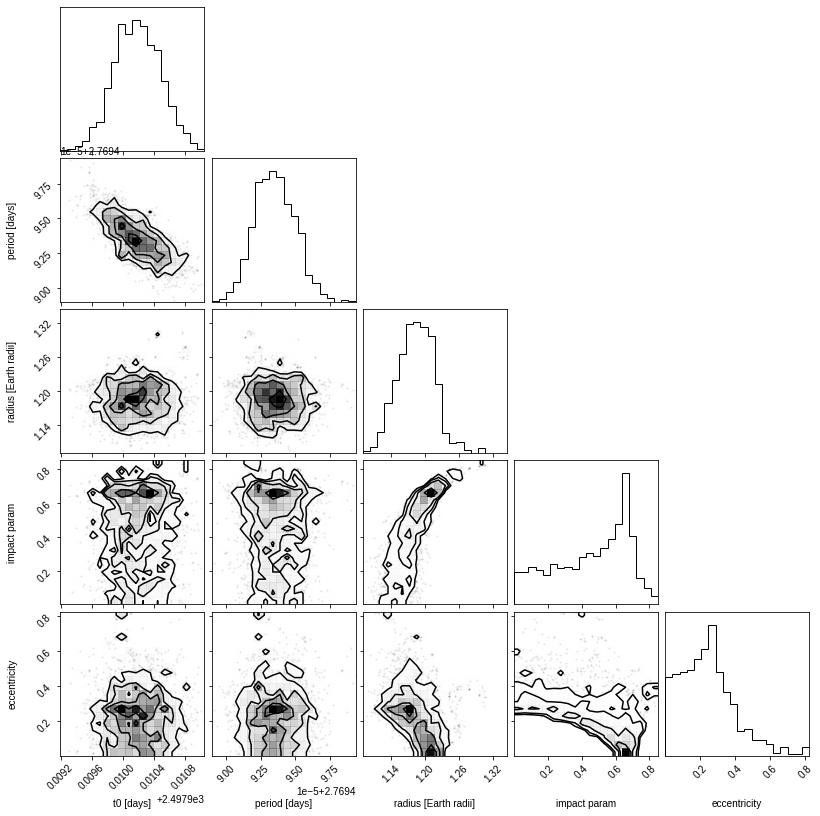

In [48]:
import corner
import astropy.units as u

trace.posterior["r_earth"] = (
    trace.posterior["r_pl"].coords,
    (trace.posterior["r_pl"].values * u.R_sun).to(u.R_earth).value,
)

_ = corner.corner(
    trace,
    var_names=["t0", "period", "r_earth", "b", "ecc"],
    labels=[
        "t0 [days]",
        "period [days]",
        "radius [Earth radii]",
        "impact param",
        "eccentricity",
    ],
)

In [44]:
transit_table = Table()
transit_table['time'] = x+2457000
transit_table['flux'] = y - gp_mod + 1
transit_table['error'] = np.array([np.std(y-gp_mod) for i in y])

ascii.write(transit_table, 
            f'../Solve_Systems/{hostname.replace(" ", "")}/{hostname.replace(" ", "")}.TESS.Sector{unique_sector_numbers[sector_ind_start]}-{unique_sector_numbers[sector_ind_end-1]}.dat', 
            names=('#time', 'flux', 'error'), 
            overwrite=True)  

In [50]:
sector_numbers

array([43, 44, 45, 71, 72, 71, 72])

In [52]:
sector_numbers[sector_ind_end]

72